# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for i in range(50):
#     lr = i
#     for j in regularization_strengths:
#         reg = j
    lr = np.random.uniform(learning_rates[1], learning_rates[2])
    reg = np.random.uniform(regularization_strengths[1], regularization_strengths[2])
    model = LinearSVM()
    losses = model.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)
    y_train_pr = model.predict(X_train_feats)
    train_acc = np.mean(y_train_pr == y_train)
    y_val_pr = model.predict(X_val_feats)
    val_acc = np.mean(y_val_pr == y_val)
    print i
#     result.append
    if val_acc > best_val:
        best_val = val_acc
        best_svm = model
    key = (lr, reg)
    value = (train_acc, val_acc)
    results[key] = value
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
# lr 3.076715e-08 reg 3.752078e+06 train accuracy: 0.418959 val accuracy: 0.436000

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
lr 1.160535e-08 reg 8.728413e+06 train accuracy: 0.407673 val accuracy: 0.417000
lr 1.254053e-08 reg 4.092061e+06 train accuracy: 0.410367 val accuracy: 0.405000
lr 1.455825e-08 reg 5.236032e+06 train accuracy: 0.400163 val accuracy: 0.408000
lr 1.614081e-08 reg 7.810818e+06 train accuracy: 0.393857 val accuracy: 0.400000
lr 2.074843e-08 reg 4.347967e+06 train accuracy: 0.395755 val accuracy: 0.400000
lr 2.167726e-08 reg 6.256585e+06 train accuracy: 0.396878 val accuracy: 0.403000
lr 2.183880e-08 reg 8.353835e+06 train accuracy: 0.386735 val accuracy: 0.376000
lr 2.231773e-08 reg 6.491707e+06 train accuracy: 0.394265 val accuracy: 0.387000
lr 2.294474e-08 reg 5.821691e+06 train accuracy: 0.405531 val accuracy: 0.412000
lr 2.754817e-08 reg 7.715646e+06 train accuracy: 0.408184 val accuracy: 0.405000
lr 2.861909e-08 reg 8.332166e+06 train accuracy: 0

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.424


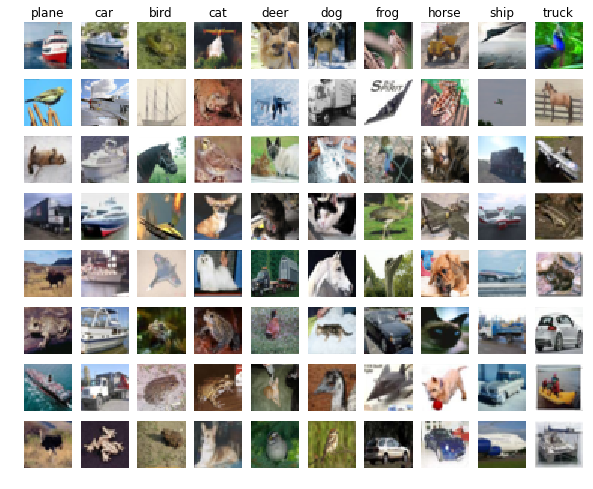

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
print X_train_feats.shape

(49000L, 155L)


0 0.581306122449 0.565 lr=  0.336486167359 reg=  0.00822877825363


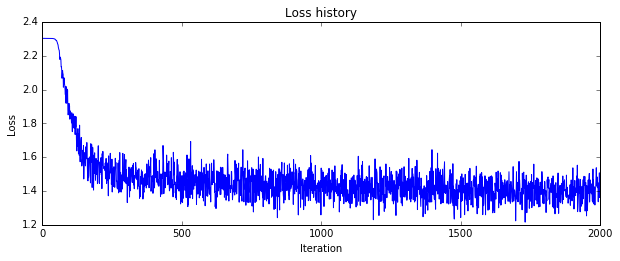

1 0.666081632653 0.601 lr=  0.499771778256 reg=  0.00225823847392


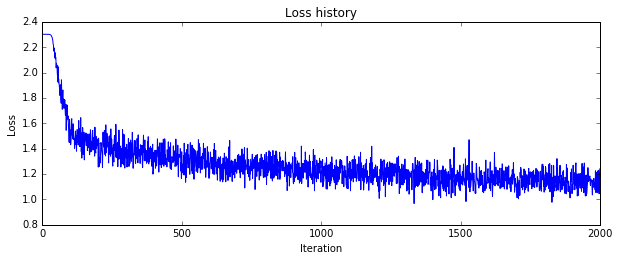

2 0.642020408163 0.579 lr=  0.345901978397 reg=  0.00187034387202


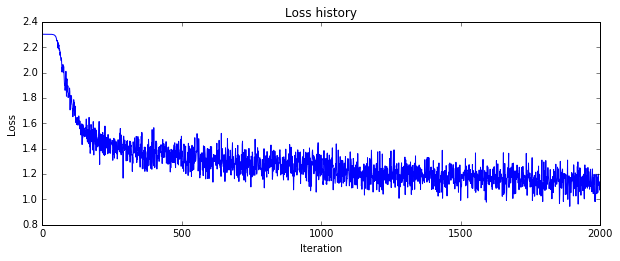

3 0.538857142857 0.516 lr=  0.101863791083 reg=  0.00413687158391


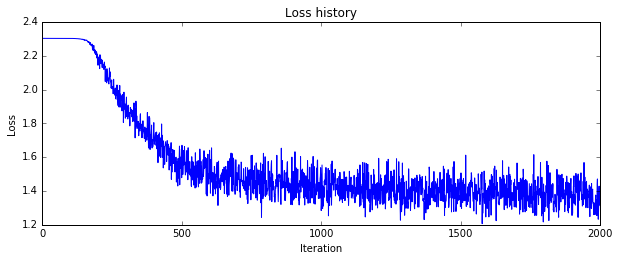

4 0.684387755102 0.597 lr=  0.489316581926 reg=  0.00104717020652


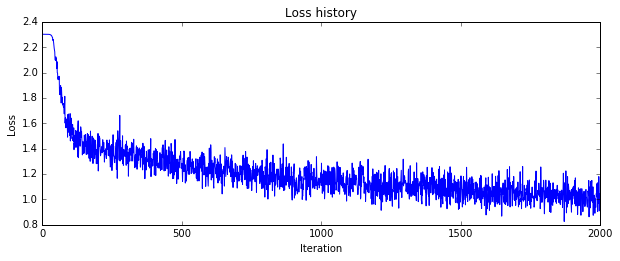

5 0.614693877551 0.581 lr=  0.576069599666 reg=  0.00609707826242


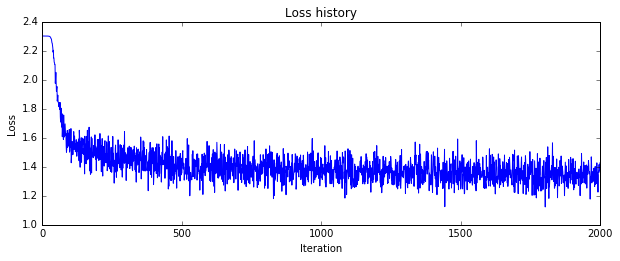

6 0.605142857143 0.572 lr=  0.557657603688 reg=  0.00702272254616


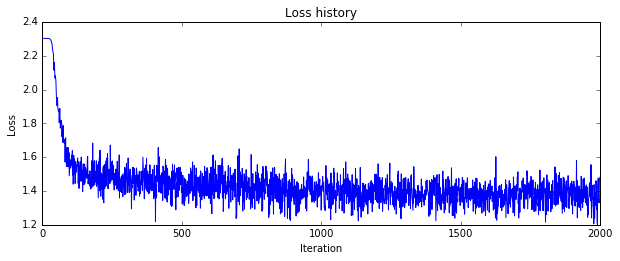

7 0.472591836735 0.47 lr=  0.04147889051 reg=  0.0053929506894


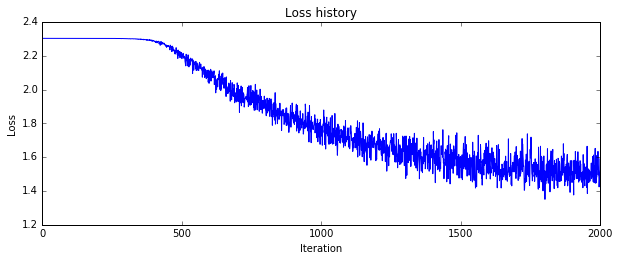

8 0.643693877551 0.597 lr=  0.302629309659 reg=  0.000788066622474


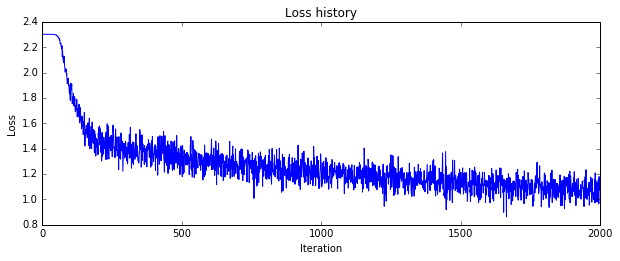

9 0.246510204082 0.262 lr=  0.000649218650128 reg=  0.00566428609616


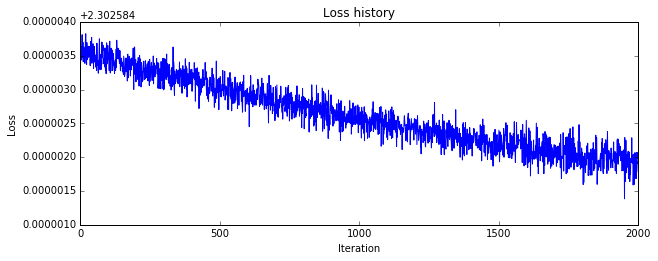

10 0.582408163265 0.572 lr=  0.255542556683 reg=  0.00615851530723


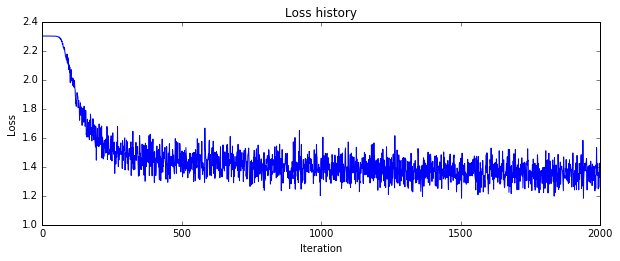

11 0.668530612245 0.586 lr=  0.454291128415 reg=  0.00165611347758


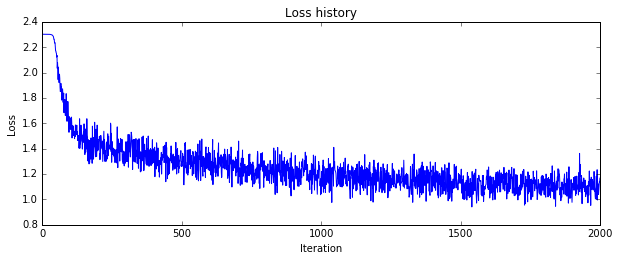

12 0.622897959184 0.577 lr=  0.316458946696 reg=  0.00292262884144


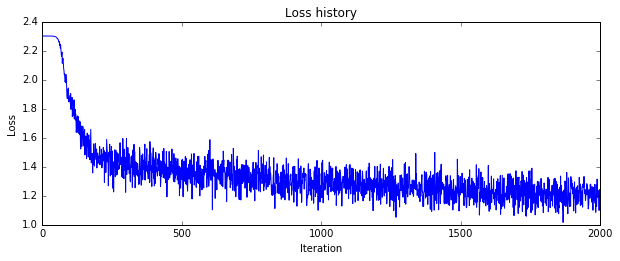

13 0.633979591837 0.582 lr=  0.573826181221 reg=  0.00459104967866


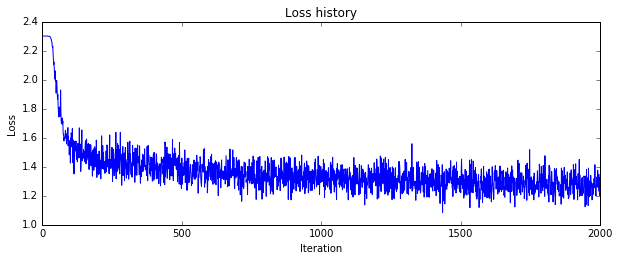

14 0.560714285714 0.547 lr=  0.168758401077 reg=  0.00614004899972


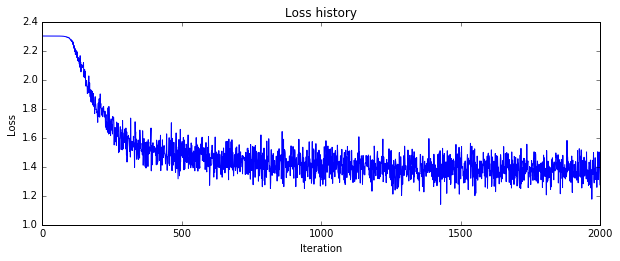

15 0.570653061224 0.552 lr=  0.350201081573 reg=  0.00978562657687


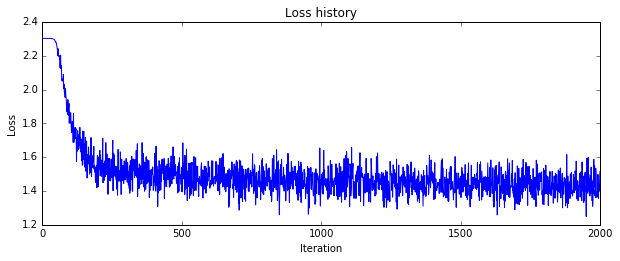

16 0.582448979592 0.552 lr=  0.170573258724 reg=  0.00147856109297


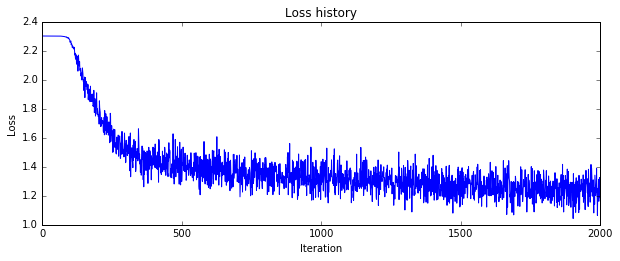

17 0.555244897959 0.531 lr=  0.193373892724 reg=  0.00899554765241


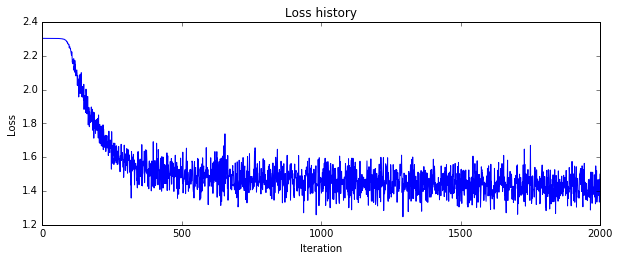

18 0.57806122449 0.551 lr=  0.480557413947 reg=  0.00984845698631


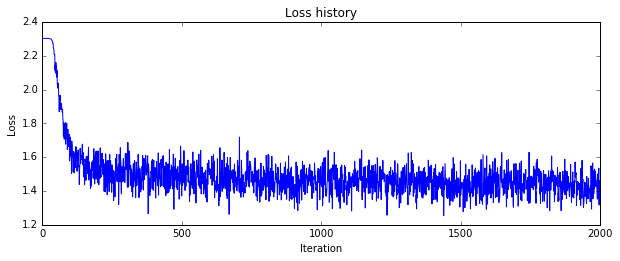

19 0.539489795918 0.524 lr=  0.0970239801757 reg=  0.00279677614901


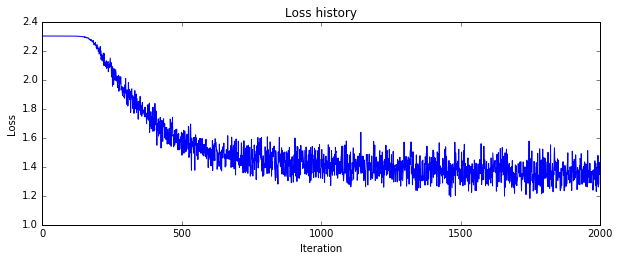

lr 6.492187e-04 reg 5.664286e-03 train accuracy: 0.246510 val accuracy: 0.262000
lr 4.147889e-02 reg 5.392951e-03 train accuracy: 0.472592 val accuracy: 0.470000
lr 9.702398e-02 reg 2.796776e-03 train accuracy: 0.539490 val accuracy: 0.524000
lr 1.018638e-01 reg 4.136872e-03 train accuracy: 0.538857 val accuracy: 0.516000
lr 1.687584e-01 reg 6.140049e-03 train accuracy: 0.560714 val accuracy: 0.547000
lr 1.705733e-01 reg 1.478561e-03 train accuracy: 0.582449 val accuracy: 0.552000
lr 1.933739e-01 reg 8.995548e-03 train accuracy: 0.555245 val accuracy: 0.531000
lr 2.555426e-01 reg 6.158515e-03 train accuracy: 0.582408 val accuracy: 0.572000
lr 3.026293e-01 reg 7.880666e-04 train accuracy: 0.643694 val accuracy: 0.597000
lr 3.164589e-01 reg 2.922629e-03 train accuracy: 0.622898 val accuracy: 0.577000
lr 3.364862e-01 reg 8.228778e-03 train accuracy: 0.581306 val accuracy: 0.565000
lr 3.459020e-01 reg 1.870344e-03 train accuracy: 0.642020 val accuracy: 0.579000
lr 3.502011e-01 reg 9.785627

In [16]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [0, 0.6]
regularization_strengths = [5e-4, 1e-2]

results = {}
best_val = -1
best_net = None

for i in range(20):
    lr = np.random.uniform(learning_rates[0], learning_rates[1])
    reg = np.random.uniform(regularization_strengths[0], regularization_strengths[1])
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    losses = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=lr, reg=reg,
                      num_iters=2000, verbose=False, batch_size=200, learning_rate_decay=0.90)
    y_train_pr = net.predict(X_train_feats)
    train_acc = np.mean(y_train_pr == y_train)
    y_val_pr = net.predict(X_val_feats)
    val_acc = np.mean(y_val_pr == y_val)
    print i, train_acc, val_acc, 'lr= ', lr, 'reg= ', reg

    if val_acc > best_val:
        best_val = val_acc
        best_net = net
    key = (lr, reg)
    value = (train_acc, val_acc)
    results[key] = value
    plt.subplot(2, 1, 1)
    plt.plot(losses['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val
# lr 4.780714e-01 reg 3.567530e-03 train accuracy: 0.645306 val accuracy: 0.598000
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [17]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.561


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!